# Hyperparameter

In [111]:
import random
import pandas as pd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

df = pd.read_csv('./data/banknotes.csv')

X = scale(df.drop('class', axis=1).values)
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)
print(X_train.shape)

def run(number_of_layers, size_of_layers, opt_name, lr, activ, init, batch):
    
    K.clear_session()

    model = Sequential()
    model.add(Dense(1, input_shape=(4,), activation=activ, kernel_initializer=init))
    for i in range(number_of_layers):
        model.add(Dense(size_of_layers, activation=activ, kernel_initializer=init))
    model.add(Dense(1, input_shape=(4,), activation=activ, kernel_initializer=init))

    model.compile(loss='binary_crossentropy',
                  optimizer=opt_name(lr=lr),
                  metrics=['accuracy'])

    h = model.fit(X_train, y_train, batch_size=batch, epochs=15, verbose=0)
    result = model.evaluate(X_test, y_test)
    params = "Layers:{} Layer Size:{} Optimizer: {} Learning Rate: {} Activation: {} Initializer: {} Batch Size: {}".format(
        number_of_layers, size_of_layers, str(opt_name).split(".")[-1][:-2], lr, activ, init, batch
    )
    return h, result, params

(960, 4)


In [112]:
number_of_layers = [1,2,3,4]
size_of_layers = [1,2,3,4]
optimizers = [SGD, Adam, RMSprop, Adagrad]
learning_rates = [0.01, 0.05, 0.1, 0.5]
activation_functions = ['sigmoid', 'relu', 'tanh']
initializers = ['zeros', 'uniform', 'normal','he_normal', 'lecun_uniform', 'glorot_uniform']
batch_sizes = [8,16,32,64]

In [113]:
dflist = []
hyperparameters = []

for i in range(20):
    history, results, params = run(
        random.choice(number_of_layers),
        random.choice(size_of_layers),
        random.choice(optimizers),
        random.choice(learning_rates),
        random.choice(activation_functions),
        random.choice(initializers),
        random.choice(batch_sizes)
    )
    hyperparameters.append(params)
    dflist.append(pd.DataFrame(history.history, index=history.epoch))
historydf = pd.concat(dflist, axis=1)

metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([hyperparameters, metrics_reported],
                                 names=['learning_rate', 'metric'])

historydf.columns = idx

412/412 [==============================] - 0s 59us/step


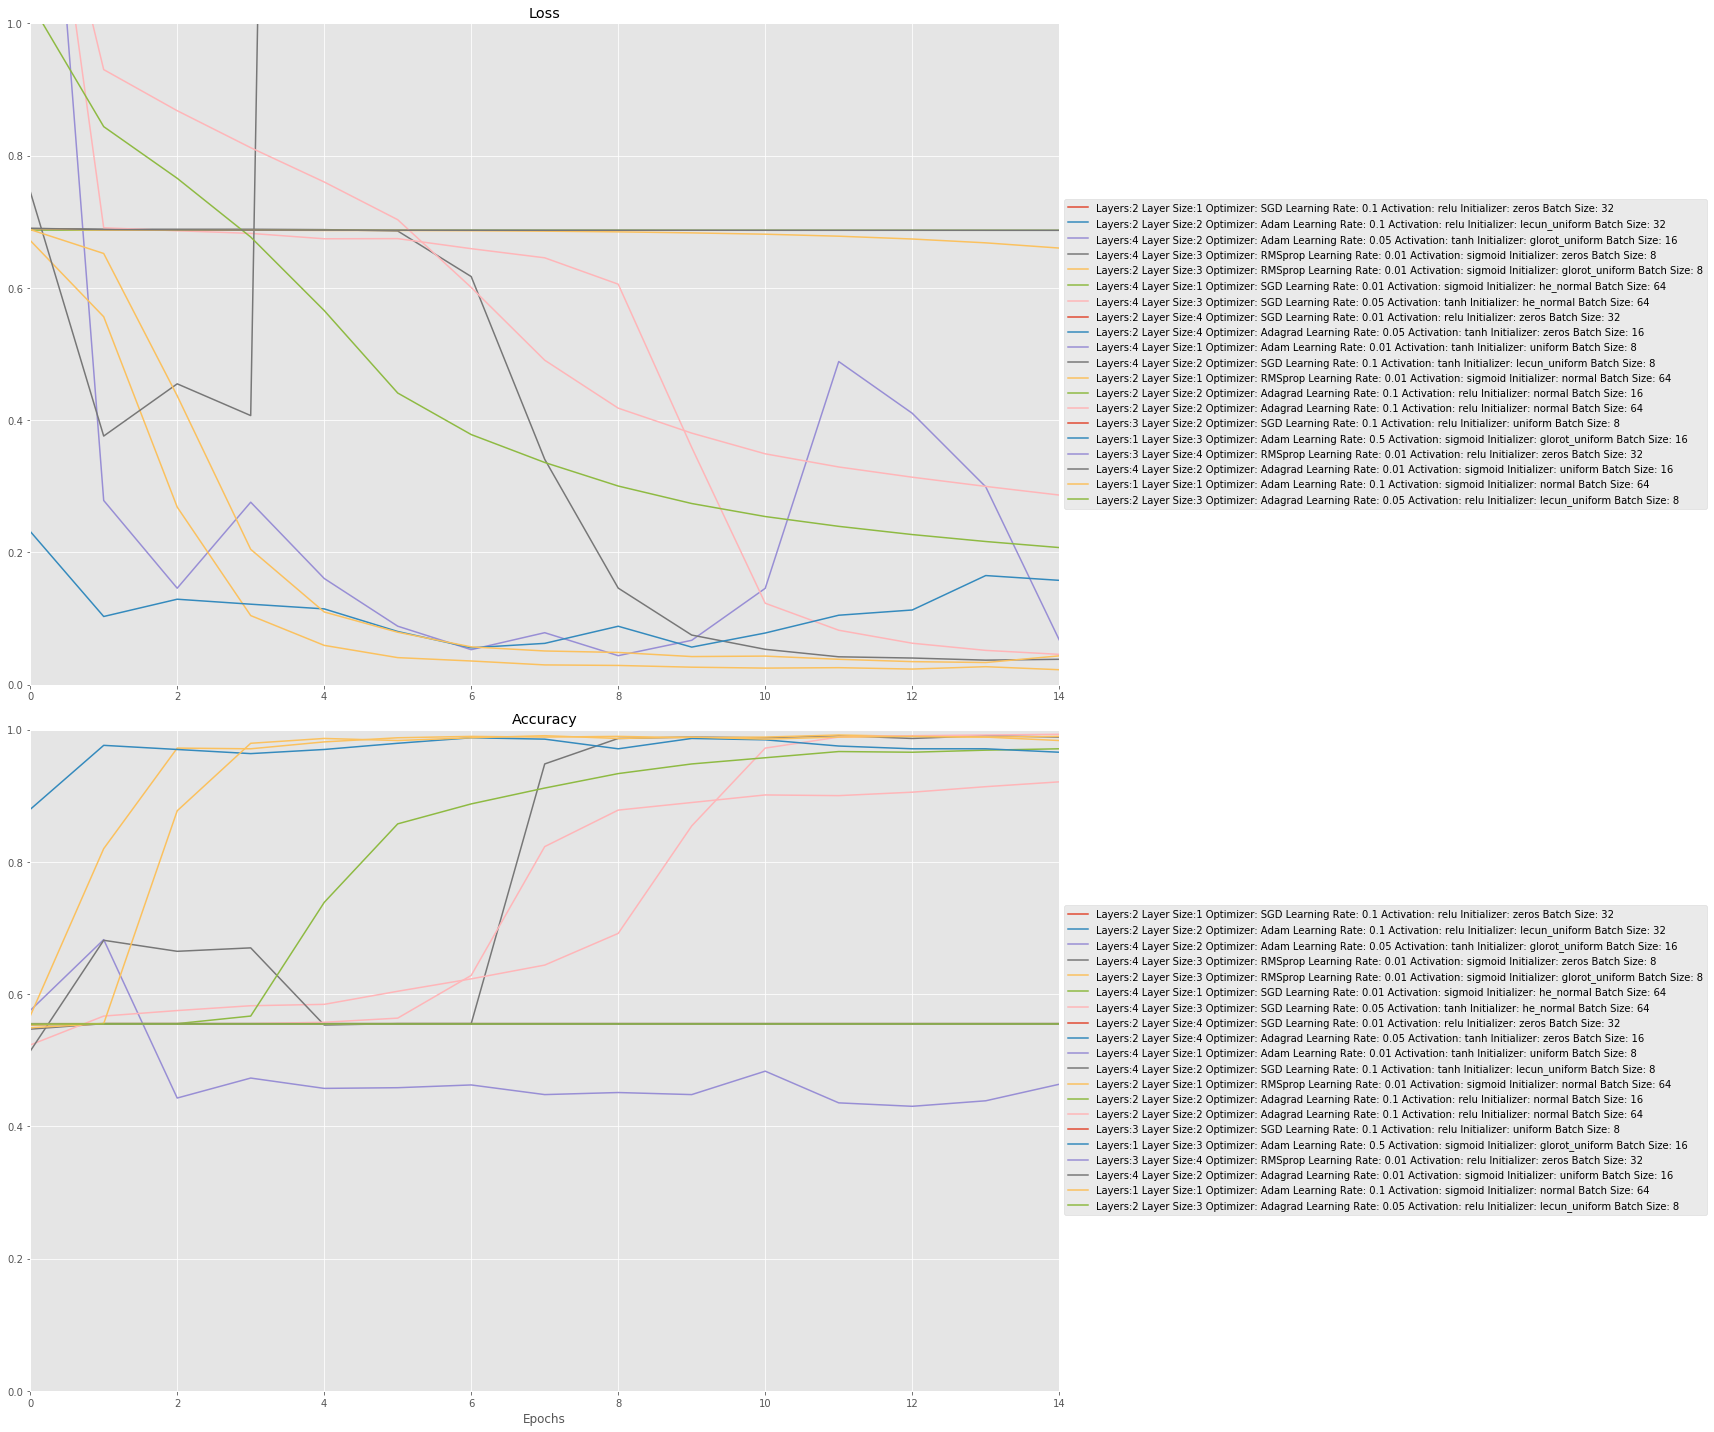

In [114]:
ax = plt.subplot(211)
historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax, figsize=(15,20)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Loss")

ax = plt.subplot(212)
historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax, figsize=(15,20)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout()

# Data Augmentation

Found 1 images belonging to 1 classes.


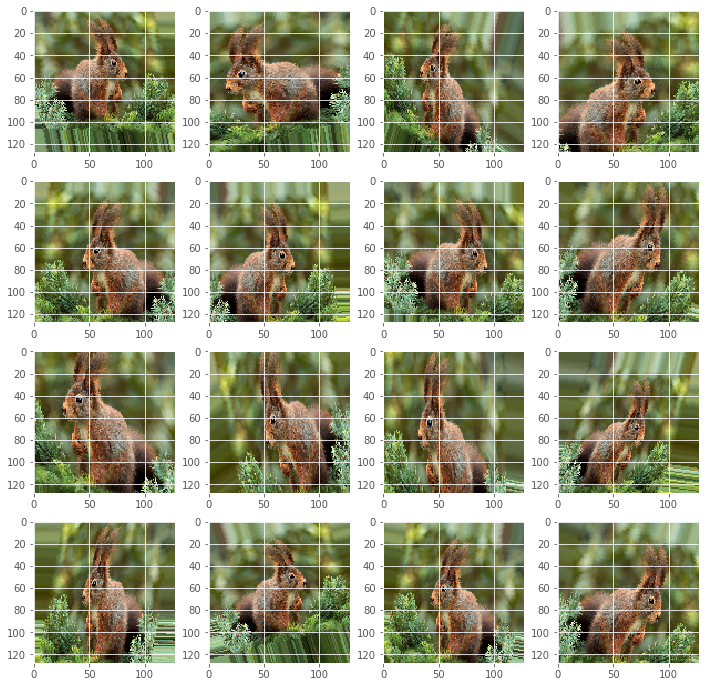

In [119]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

train = generator.flow_from_directory('./data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

# Computer Vision

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

from keras.datasets import cifar10
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Using TensorFlow backend.


170483712/170498071 [============================>.] - ETA: 0s

In [2]:
K.clear_session()

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
__________

In [3]:
# Fit the model
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), validation_split=0.2, epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 102s - loss: 1.8385 - acc: 0.3205 - val_loss: 1.5293 - val_acc: 0.4356
Epoch 2/25
50000/50000 [==============================] - 59s - loss: 1.3992 - acc: 0.4901 - val_loss: 1.2732 - val_acc: 0.5334
Epoch 3/25
50000/50000 [==============================] - 59s - loss: 1.2025 - acc: 0.5666 - val_loss: 1.1390 - val_acc: 0.5958
Epoch 4/25
50000/50000 [==============================] - 59s - loss: 1.0473 - acc: 0.6254 - val_loss: 0.9914 - val_acc: 0.6446
Epoch 5/25
50000/50000 [==============================] - 59s - loss: 0.9392 - acc: 0.6678 - val_loss: 0.8890 - val_acc: 0.6836
Epoch 6/25
50000/50000 [==============================] - 59s - loss: 0.8516 - acc: 0.6980 - val_loss: 0.8287 - val_acc: 0.7081
Epoch 7/25
50000/50000 [==============================] - 59s - loss: 0.7888 - acc: 0.7215 - val_loss: 0.7914 - val_acc: 0.7209
Epoch 8/25
50000/50000 [=============================

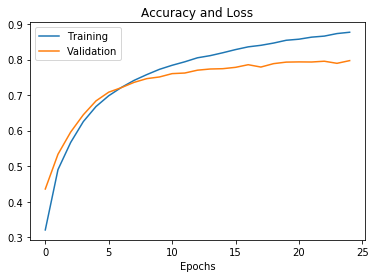

In [8]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
#plt.plot(h.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.title('Accuracy and Loss')
plt.xlabel('Epochs')

In [11]:
# why is training performance better than validation? 10%
# learned by heart, why is this a truck?
print(h.history)

{'acc': [0.32050000000000001, 0.49014000000000002, 0.56655999999999995, 0.62538000000000005, 0.66776000000000002, 0.69799999999999995, 0.72145999999999999, 0.74129999999999996, 0.75751999999999997, 0.77236000000000005, 0.78378000000000003, 0.79359999999999997, 0.80486000000000002, 0.81089999999999995, 0.81906000000000001, 0.82794000000000001, 0.83565999999999996, 0.83999999999999997, 0.84630000000000005, 0.85418000000000005, 0.85718000000000005, 0.86295999999999995, 0.8659, 0.87304000000000004, 0.87675999999999998], 'val_loss': [1.5292999771118163, 1.2731909782409667, 1.1389979320526122, 0.99141603078842166, 0.88897705421447759, 0.82865697278976436, 0.79135333948135378, 0.75650414791107179, 0.72379032640457153, 0.71505128688812258, 0.69332432422637935, 0.68190643548965457, 0.67442352848052978, 0.65170939941406247, 0.65658437309265139, 0.6435990884304047, 0.62690576176643376, 0.64784149813652037, 0.62436301479339595, 0.62305340952873234, 0.61755027985572819, 0.62563546628952027, 0.62027